In [55]:
import os
from datetime import datetime, timedelta
from pyspark.sql import SparkSession, functions as f
import matplotlib.pyplot as plt
from pyspark.sql.functions import explode, col, date_format
from pyspark.sql.types import *

In [2]:
# Define a raiz do projeto
os.chdir('/home/jovyan/')

## Session

In [14]:
# Minio
MINIO_ENDPOINT = os.getenv("MINIO_ENDPOINT_", "minioserver:9000")
MINIO_ACCESS_KEY = os.getenv("MINIO_ACCESS_KEY_", "embuuWvqBMTLPRnbYXxu")
MINIO_SECRET_KEY = os.getenv("MINIO_SECRET_KEY_", "ZApLkWzj71pCNrB0IBGvQ5s5a2x4AJ42XSFZxb39")

# Postgres
POSTGRES_DB = os.getenv("POSTGRES_DB", "z106")
POSTGRES_USER = os.getenv("POSTGRES_USER", "postgres")
POSTGRES_PASSWORD = os.getenv("POSTGRES_PASSWORD", "z106pass")
POSTGRES_HOST = os.getenv("POSTGRES_HOST", "localhost:35432")

# Remote
MINIO_BUCKET = os.getenv("MINIO_BUCKET", "z106")

In [5]:
%%time

spark = (
    SparkSession.builder.appName("DW_z106")
    .config("spark.jars.packages", "org.postgresql:postgresql:42.7.4")
    .config("spark.hadoop.fs.s3a.endpoint", MINIO_ENDPOINT)
    .config("spark.hadoop.fs.s3a.access.key", MINIO_ACCESS_KEY)
    .config("spark.hadoop.fs.s3a.secret.key", MINIO_SECRET_KEY)
    .config("spark.hadoop.fs.s3a.connection.ssl.enabled", "false")
    .config("spark.hadoop.fs.s3a.path.style.access", "true")
    .getOrCreate()
)

CPU times: user 202 ms, sys: 63.1 ms, total: 265 ms
Wall time: 16.1 s


## Carga de dados Dimensões

In [6]:
def query_postgres(spark, query):
    df = (
        spark.read.format("jdbc")
        .option("driver", "org.postgresql.Driver")
        .option("url", f"jdbc:postgresql://{POSTGRES_HOST}/{POSTGRES_DB}")
        .option("user", POSTGRES_USER)
        .option("password", POSTGRES_PASSWORD)
        .option("query", query)
        .load()
    )
    return df

### Clientes

In [7]:
%%time
query = "SELECT * FROM customers"
df_customers = query_postgres(spark, query)

# Criando a dimensão de clientes
df_customers.createOrReplaceTempView("dm_customers")

CPU times: user 12.6 ms, sys: 3.55 ms, total: 16.1 ms
Wall time: 1.67 s


### Produtos

In [10]:
%%time
query = "SELECT * FROM products"
df_products = query_postgres(spark, query)

# Criando a dimensão de produtos
df_products.createOrReplaceTempView("dm_products")

CPU times: user 5.04 ms, sys: 2.61 ms, total: 7.65 ms
Wall time: 78.3 ms


### Data

In [16]:
def generate_date_df(spark, start_date, end_date):
    date_list = [start_date + timedelta(days=x) for x in range(0, (end_date - start_date).days + 1)]
    return spark.createDataFrame(date_list, DateType()).toDF("date")

In [22]:
# Data de início e fim
start_date = datetime(2023, 1, 1)
end_date = datetime(2023, 12, 31)

# Gerando o DataFrame de datas
df_dates = generate_date_df(spark, start_date, end_date)

In [25]:
# Adicionando colunas de tempo
df_time = df_dates.withColumn("year", f.year("date")) \
                  .withColumn("month", f.month("date")) \
                  .withColumn("day", f.dayofmonth("date")) \
                  .withColumn("weekday", f.date_format("date", "E")) \
                  .withColumn("week_of_year", f.weekofyear("date"))

# Criando a dimensão de tempo
df_time.createOrReplaceTempView("dm_time")

## Carga de dados Fato

In [66]:
%%time
query = "SELECT * FROM ft_orders"
ft_orders_df = query_postgres(spark, query)

# Criando a dimensão de produtos
ft_orders_df.createOrReplaceTempView("ft_orders")

CPU times: user 14.7 ms, sys: 5.51 ms, total: 20.2 ms
Wall time: 136 ms


## Salvando Dimensões como Parquet

In [68]:
# Salvar o DataFrame em formato Parquet no MinIO
df_customers.write.mode("overwrite").parquet(f"s3a://{MINIO_BUCKET}/dw/dm_customers")
df_products.write.mode("overwrite").parquet(f"s3a://{MINIO_BUCKET}/dw/dm_products")
df_time.write.mode("overwrite").parquet(f"s3a://{MINIO_BUCKET}/dw/dm_time")
ft_orders_df.write.mode("overwrite").parquet(f"s3a://{MINIO_BUCKET}/dw/ft_orders")

## ToPandas timestamp fix

In [56]:
pdf = df_orders.limit(10) \
    .withColumn("created_at", date_format("created_at", "yyyy-MM-dd HH:mm:ss")) \
    .withColumn("charges_created_at", date_format("charges_created_at", "yyyy-MM-dd HH:mm:ss")) \
    .withColumn("charges_paid_at", date_format("charges_paid_at", "yyyy-MM-dd HH:mm:ss")) \
    .toPandas()

In [34]:
# Lendo os arquivos Parquet
ft_orders_df = spark.read.parquet(f"s3a://{MINIO_BUCKET}/dw/ft_orders")
customers_df = spark.read.parquet(f"s3a://{MINIO_BUCKET}/dw/dm_customers")
products_df = spark.read.parquet(f"s3a://{MINIO_BUCKET}/dw/dm_products")
time_df = spark.read.parquet(f"s3a://{MINIO_BUCKET}/dw/dm_time")

#### Receita Total por Cliente (Top 10)

In [39]:
receita_por_cliente_df = ft_orders_df \
    .groupBy('customer') \
    .agg(f.sum('charge_value').alias('total_revenue')) \
    .orderBy('total_revenue', ascending=False) \
    .limit(10)

receita_por_cliente = receita_por_cliente_df.toPandas()
clientes = receita_por_cliente['customer'].fillna('Desconhecido')  # Substituir valores None
receitas = receita_por_cliente['total_revenue']
receita_por_cliente

,customer,total_revenue
0,CID_7b92ed6e-a295-4660-81ec-f791c43dab55,484853.7
1,CID_15c89328-d811-44bd-b3bf-2f7d7d762f82,483965.6
2,CID_a0968e80-f110-4303-8722-f676008fc0a9,483142.2
3,CID_4e6ba3cd-8569-4f42-b970-4a10ace38b04,480727.2
4,CID_44b92be4-f642-4f43-b8e3-7c1e3f386dd2,480242.0
5,CID_09d30c02-c4d6-440d-9cf0-d1c9b547875c,478803.3
6,CID_2b264738-bfaa-4851-9aee-3e867ccef4eb,478699.6
7,CID_1b07183a-7d49-4106-a230-acd5dd51cfaa,475409.4
8,CID_54f55b0e-2880-4a68-b08f-fb61da49e190,474288.5
9,CID_44c24903-e8c8-4e35-92d6-2756f3f30c76,474155.2


#### Número de Pedidos por Categoria de Produto

In [41]:
items_df = ft_orders_df.withColumn('item', explode(col('item_references')))
items_df = items_df.select('item', 'charge_value')
pedidos_por_produto_df = items_df.join(products_df, items_df.item == products_df.reference_id, 'left') \
    .groupBy('category') \
    .agg(f.count('item').alias('order_count'))

categorias_df = pedidos_por_produto_df.toPandas()
categorias = categorias_df['category'].fillna('Desconhecida')  # Substituir valores None
quantidade_pedidos = categorias_df['order_count']


In [36]:
# Receita Total por Mês
receita_mensal_df = ft_orders_df \
    .join(time_df, ft_orders_df.created_at.cast('date') == time_df.date, 'left') \
    .groupBy('year', 'month') \
    .agg(f.sum('charge_value').alias('total_revenue')) \
    .orderBy('year', 'month')

receita_mensal = receita_mensal_df.toPandas()

# Garantir que os valores de year e month são inteiros
receita_mensal['month'] = receita_mensal['month'].fillna(0).astype(int)
receita_mensal['year'] = receita_mensal['year'].fillna(0).astype(int)

# Criar o período no formato 'YYYY-MM'
receita_mensal['period'] = receita_mensal.apply(lambda x: f"{int(x['year']):04d}-{int(x['month']):02d}", axis=1)
meses = receita_mensal['period']
receitas_por_mes = receita_mensal['total_revenue']

NameError: name 'categorias' is not defined

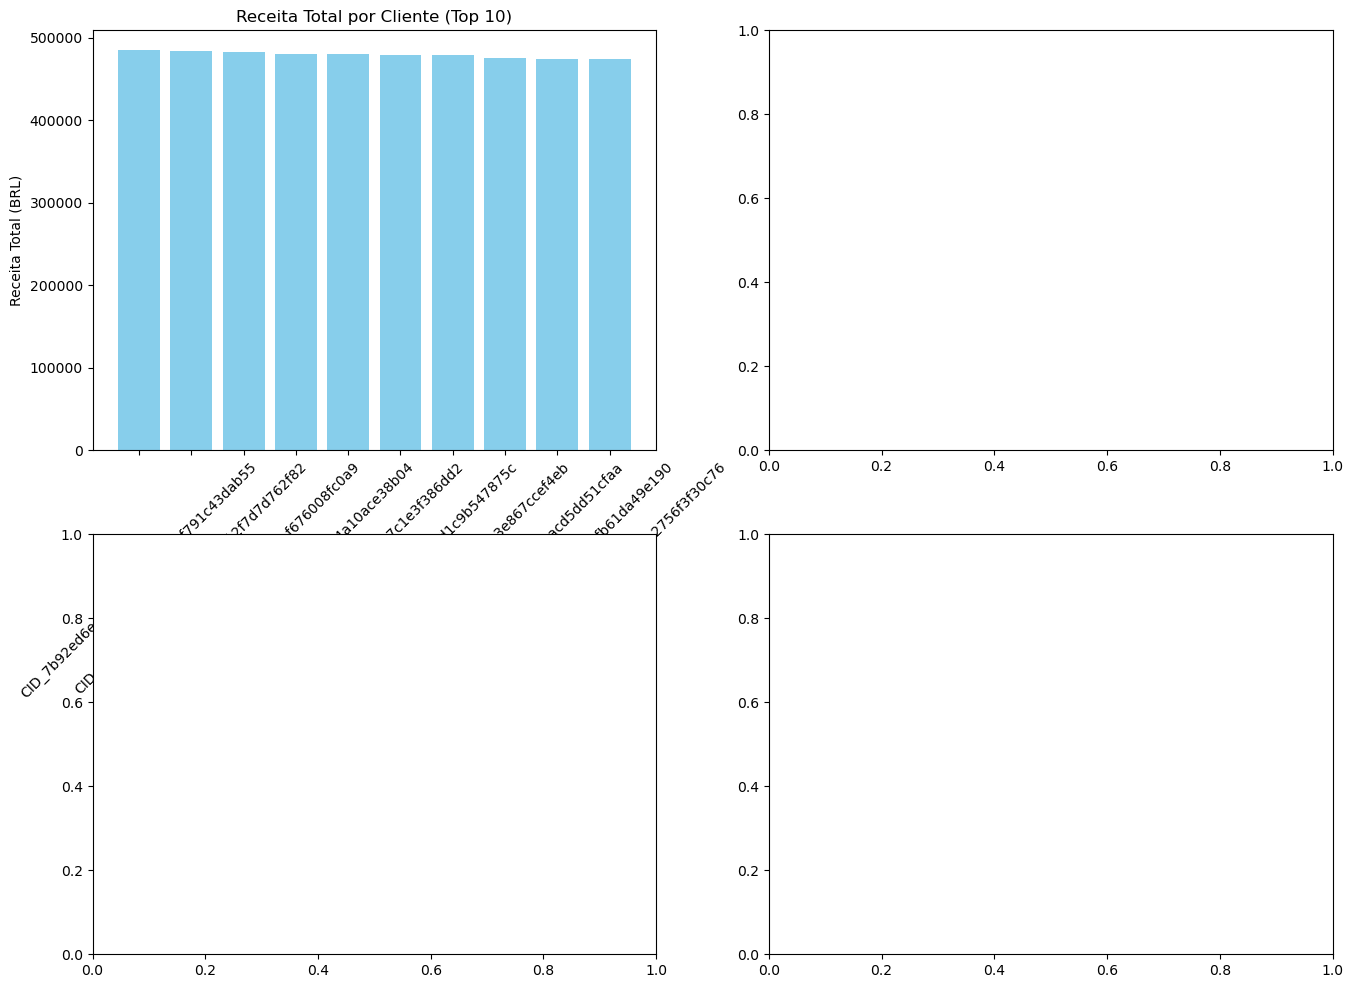

In [42]:
# Número de Pedidos por Estado de Entrega
shipping_df = ft_orders_df.withColumn(
    'shipping_region_code',
    f.get_json_object(f.col('shipping'), '$.region_code')
)
quantidade_pedidos_por_estado_df = shipping_df \
    .groupBy('shipping_region_code') \
    .agg(f.count('id').alias('order_count'))

estados_df = quantidade_pedidos_por_estado_df.toPandas()
estados = estados_df['shipping_region_code'].fillna('Desconhecido')  # Substituir valores None
quantidade_pedidos_por_estado = estados_df['order_count']

# Criar subplots
fig, axs = plt.subplots(2, 2, figsize=(16, 12))

# Receita Total por Cliente (Top 10)
axs[0, 0].bar(clientes, receitas, color='skyblue')
axs[0, 0].set_title('Receita Total por Cliente (Top 10)')
axs[0, 0].set_xlabel('Cliente')
axs[0, 0].set_ylabel('Receita Total (BRL)')
axs[0, 0].tick_params(axis='x', rotation=45)

# Número de Pedidos por Categoria de Produto
axs[0, 1].bar(categorias, quantidade_pedidos, color='lightgreen')
axs[0, 1].set_title('Número de Pedidos por Categoria de Produto')
axs[0, 1].set_xlabel('Categoria do Produto')
axs[0, 1].set_ylabel('Número de Pedidos')
axs[0, 1].tick_params(axis='x', rotation=45)

# Receita Total por Mês
axs[1, 0].plot(meses, receitas_por_mes, marker='o', linestyle='-', color='coral')
axs[1, 0].set_title('Receita Total por Mês')
axs[1, 0].set_xlabel('Mês')
axs[1, 0].set_ylabel('Receita Total (BRL)')
axs[1, 0].tick_params(axis='x', rotation=45)

# Número de Pedidos por Estado de Entrega
axs[1, 1].bar(estados, quantidade_pedidos_por_estado, color='lightcoral')
axs[1, 1].set_title('Número de Pedidos por Estado de Entrega')
axs[1, 1].set_xlabel('Estado de Entrega')
axs[1, 1].set_ylabel('Número de Pedidos')
axs[1, 1].tick_params(axis='x', rotation=45)

# Ajustar layout e mostrar
plt.tight_layout()
plt.show()